Import modules

In [70]:
import numpy as np
import argparse
import os
from skimage import io, color, exposure, transform
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
import sys
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import callbacks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [71]:
DEV = False
argvs = sys.argv
argc = len(argvs)

Setting the epoch and the initial parameters experimentally 

In [72]:
if argc > 1 and (argvs[1] == "--development" or argvs[1] == "-d"):
  DEV = True

if DEV:
  epochs = 2
else:
  epochs = 20

In [73]:
"""
Parameters
"""
img_width, img_height = 32, 32
batch_size = 32
samples_per_epoch = 1000
validation_steps = 300
nb_filters1 = 64
conv_size1 = 3
nb_filters2 = 32
conv_size2 = 2
pool_size = 2
classes_num = 5
lr = 0.0004

Building CNN model

In [74]:
def build_cnn(input_size, num):
    model = Sequential()
    
    model.add(Conv2D(nb_filters1, conv_size1, conv_size1, border_mode ="same", input_shape=(img_width, img_height, 3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

    model.add(Conv2D(nb_filters2, conv_size2, conv_size2, border_mode ="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size), dim_ordering='th'))

    model.add(Conv2D(64, (5, 5)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num))
    model.add(Activation("softmax"))
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['accuracy'])

    return model

Summary of the model

In [75]:
model = build_cnn(32,5)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 32)        8224      
_________________________________________________________________
batch_normalization_18 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_30 (Activation)   (None, 16, 16, 32)        0         
__________

In [76]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Not required ultimately

Function to load training data. (I divided the initial dataset into 90:10 for training:testing).
The training data is now further split into training and validation data 90:10

In [77]:
def load_d(path, val_size=0.1):
    if not os.path.exists(path):
        raise IOError('directory does not exist')
    classes = os.listdir(path)
    indx = {c: i for i, c in enumerate(classes)}
    X = []
    y = []
    for c in classes:
        cp = os.path.join(path, c)
        img_paths = os.listdir(cp)
        label = np.zeros(len(classes), dtype=np.float32)
        label[indx[c]] = 1.0
        for ip in img_paths:
            img = Image.open(os.path.join(cp, ip))
            img = img.resize((32, 32))
            img = np.array(img, dtype=np.float32) / 255.0
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=val_size)
    return X_train, X_test, y_train, y_test, indx

def load_test(path):
    if not os.path.exists(path):
        raise IOError('directory does not exist')
    classes = os.listdir(path)
    indx = {c: i for i, c in enumerate(classes)}
    X = []
    y = []
    for c in classes:
        cp = os.path.join(path, c)
        img_paths = os.listdir(cp)
        label = np.zeros(len(classes), dtype=np.float32)
        label[indx[c]] = 1.0
        for ip in img_paths:
            img = Image.open(os.path.join(cp, ip))
            img = img.resize((32, 32))
            img = np.array(img, dtype=np.float32) / 255.0
            X.append(img)
            y.append(label)
    
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)


    return X,y,indx

X_train, X_test, y_train, y_test, indx = load_d(path="flow/")
print(indx)

{'daisy': 0, 'sunflower': 1, 'tulip': 2, 'dandelion': 3, 'rose': 4}


Checkpoints let us save intermediate values, to protect long run values

In [78]:
img_size = 32
batch_size = 32
epochs = 20

callbacks = [TensorBoard(log_dir='./logs/', batch_size=batch_size),
             ModelCheckpoint(filepath='./checkpoints/{epoch:02d}-{val_acc:.2f}.h5', monitor='val_loss', save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)]

if not os.path.exists('./checkpoints/'):
    os.mkdir('./checkpoints/')

Training 

In [79]:
model.fit(x=X_train, 
          y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(X_test, y_test),
          shuffle=True,
          )


model.save_weights('modelo.h5')

Train on 3890 samples, validate on 433 samples
Epoch 1/20
3890/3890 [==============================] - 35s 9ms/step - loss: 1.6880 - acc: 0.3267 - val_loss: 1.2319 - val_acc: 0.4988
Epoch 2/20
3890/3890 [==============================] - 24s 6ms/step - loss: 1.3575 - acc: 0.4440 - val_loss: 1.1382 - val_acc: 0.5173
Epoch 3/20
3890/3890 [==============================] - 24s 6ms/step - loss: 1.2586 - acc: 0.4943 - val_loss: 1.0838 - val_acc: 0.5358
Epoch 4/20
3890/3890 [==============================] - 23s 6ms/step - loss: 1.1862 - acc: 0.5324 - val_loss: 1.0118 - val_acc: 0.6005
Epoch 5/20
3890/3890 [==============================] - 24s 6ms/step - loss: 1.1171 - acc: 0.5679 - val_loss: 0.9534 - val_acc: 0.5889
Epoch 6/20
3890/3890 [==============================] - 25s 6ms/step - loss: 1.0633 - acc: 0.5905 - val_loss: 1.0520 - val_acc: 0.5335
Epoch 7/20
3890/3890 [==============================] - 25s 6ms/step - loss: 0.9966 - acc: 0.6108 - val_loss: 0.9148 - val_acc: 0.6397
Epoch 8/

Load saved model

In [80]:
model.load_weights('modelo.h5')

indx = {'daisy': 0, 'sunflower': 1, 'tulip': 2, 'dandelion': 3, 'rose': 4}

idx2class = {v: key for key, v in indx.items()}

Load the test dataset

In [81]:
X_test,Y_test, indx = load_test("test/")
X_test = X_test.reshape(X_test.shape[0],32,32,3)

Evaluating accuracy of the model :

In [82]:
score = model.evaluate(X_test, Y_test, verbose=0)

In [83]:
print('Test accuracy:', score[1])

Test accuracy: 0.8677494203684778


Now we will get labels of the test datset, so that we can compare the model's performance with actual labels

In [88]:
correct_class = []
for i in range(len(Y_test)):
    for j in range(len(Y_test[i])):
        if(Y_test[i][j] == 1.0):
            correct_class.append(j)

In [89]:
print(correct_class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

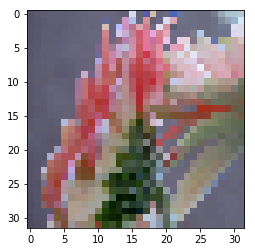

Predicted as-> rose
Correct class-> daisy


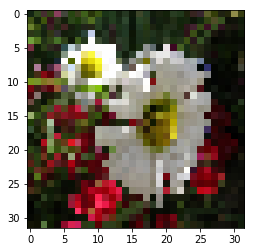

Predicted as-> rose
Correct class-> daisy


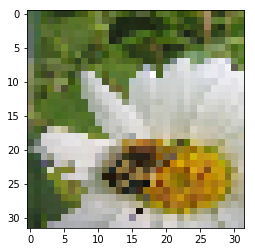

Predicted as-> rose
Correct class-> daisy


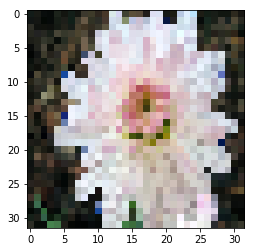

Predicted as-> rose
Correct class-> daisy


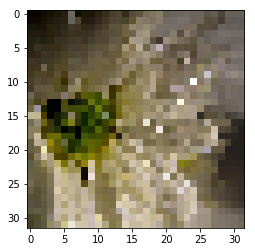

Predicted as-> dandelion
Correct class-> daisy


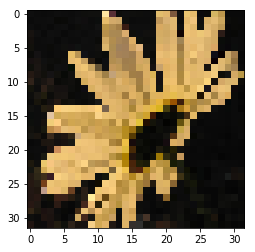

Predicted as-> rose
Correct class-> daisy


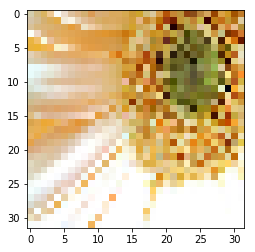

Predicted as-> rose
Correct class-> daisy


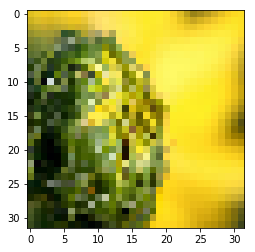

Predicted as-> dandelion
Correct class-> sunflower


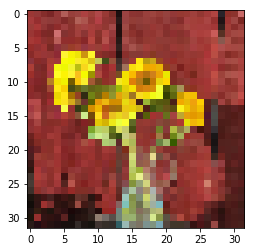

Predicted as-> tulip
Correct class-> sunflower


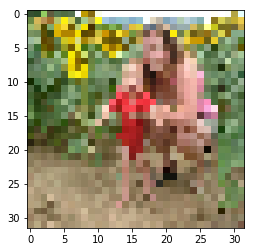

Predicted as-> rose
Correct class-> sunflower


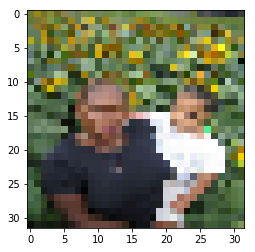

Predicted as-> daisy
Correct class-> sunflower


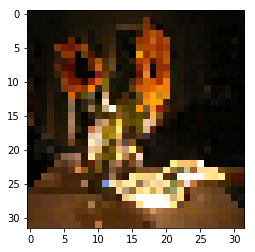

Predicted as-> rose
Correct class-> sunflower


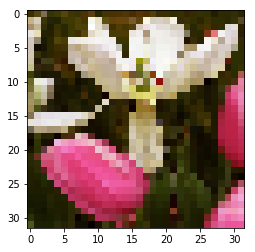

Predicted as-> rose
Correct class-> tulip


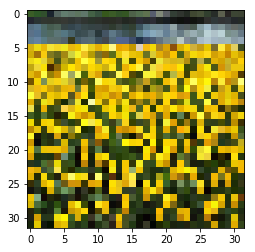

Predicted as-> dandelion
Correct class-> tulip


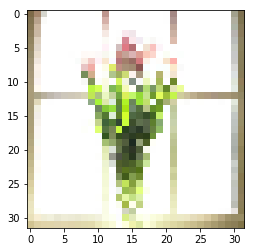

Predicted as-> daisy
Correct class-> tulip


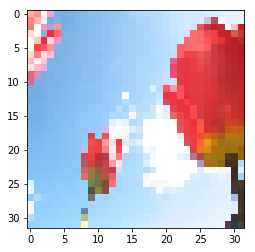

Predicted as-> rose
Correct class-> tulip


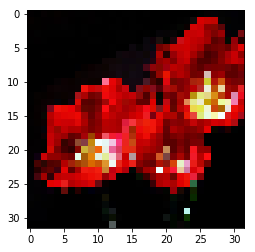

Predicted as-> rose
Correct class-> tulip


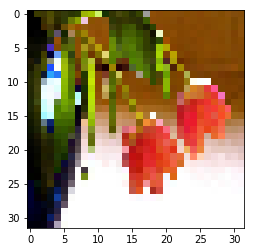

Predicted as-> rose
Correct class-> tulip


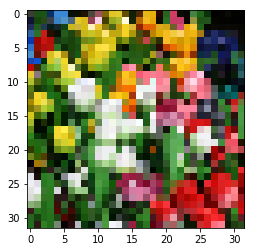

Predicted as-> daisy
Correct class-> tulip


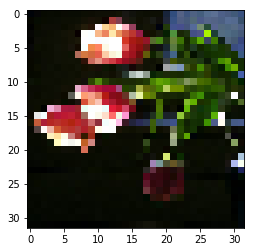

Predicted as-> rose
Correct class-> tulip


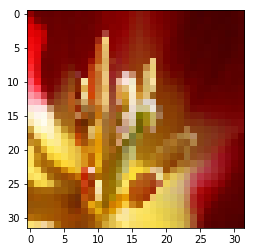

Predicted as-> rose
Correct class-> tulip


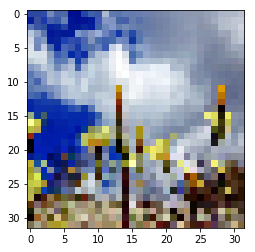

Predicted as-> tulip
Correct class-> dandelion


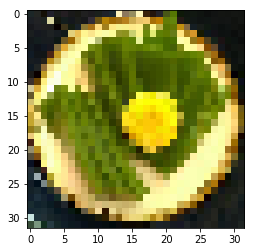

Predicted as-> daisy
Correct class-> dandelion


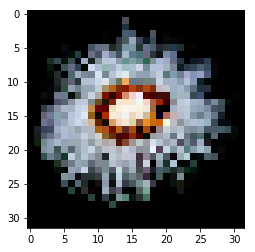

Predicted as-> daisy
Correct class-> dandelion


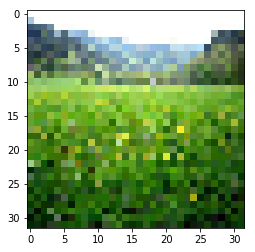

Predicted as-> sunflower
Correct class-> dandelion


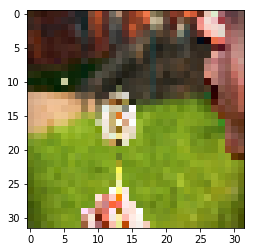

Predicted as-> daisy
Correct class-> dandelion


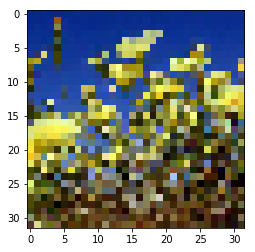

Predicted as-> sunflower
Correct class-> dandelion


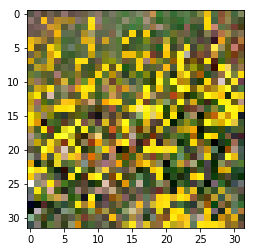

Predicted as-> sunflower
Correct class-> dandelion


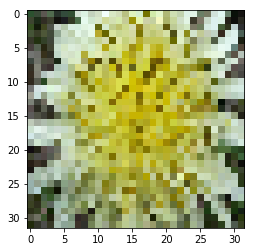

Predicted as-> daisy
Correct class-> dandelion


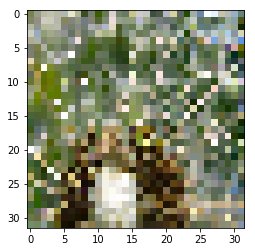

Predicted as-> daisy
Correct class-> dandelion


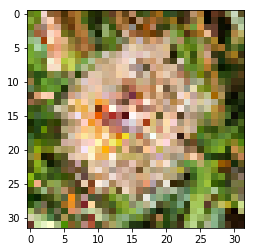

Predicted as-> rose
Correct class-> dandelion


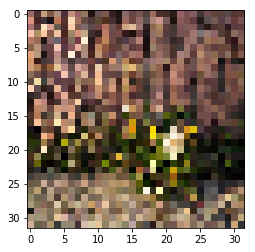

Predicted as-> rose
Correct class-> dandelion


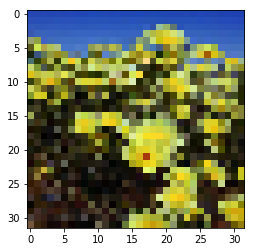

Predicted as-> sunflower
Correct class-> dandelion


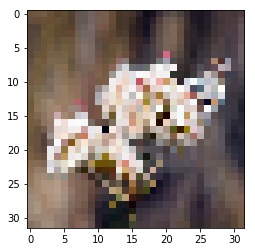

Predicted as-> daisy
Correct class-> dandelion


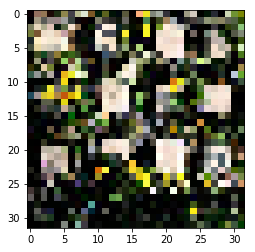

Predicted as-> daisy
Correct class-> dandelion


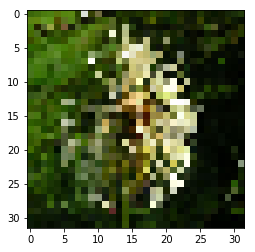

Predicted as-> daisy
Correct class-> dandelion


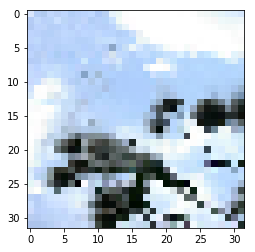

Predicted as-> daisy
Correct class-> dandelion


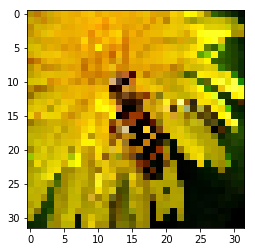

Predicted as-> sunflower
Correct class-> dandelion


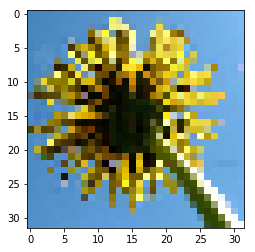

Predicted as-> sunflower
Correct class-> dandelion


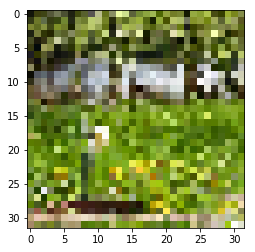

Predicted as-> daisy
Correct class-> dandelion


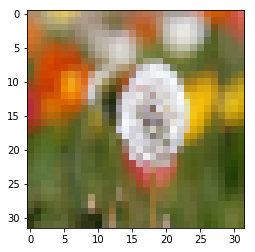

Predicted as-> daisy
Correct class-> dandelion


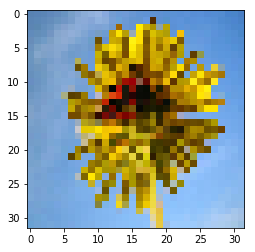

Predicted as-> sunflower
Correct class-> dandelion


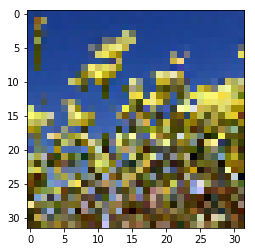

Predicted as-> sunflower
Correct class-> dandelion


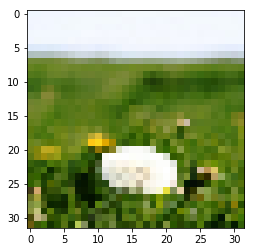

Predicted as-> daisy
Correct class-> dandelion


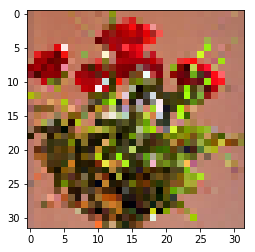

Predicted as-> tulip
Correct class-> rose


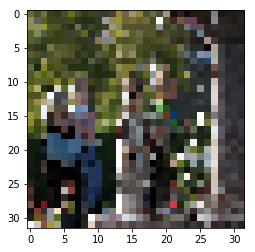

Predicted as-> tulip
Correct class-> rose


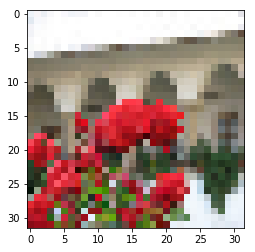

Predicted as-> tulip
Correct class-> rose


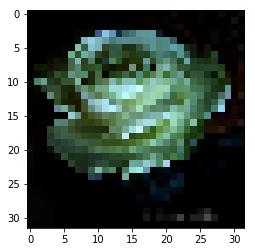

Predicted as-> daisy
Correct class-> rose


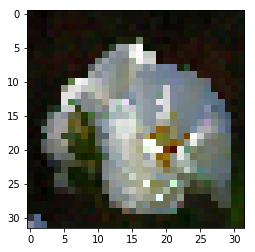

Predicted as-> daisy
Correct class-> rose


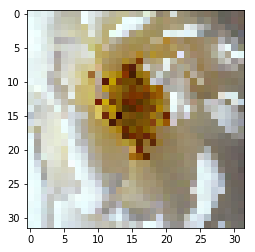

Predicted as-> daisy
Correct class-> rose


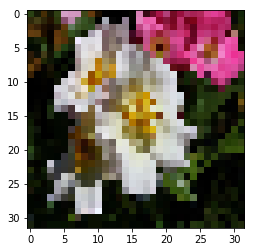

Predicted as-> daisy
Correct class-> rose


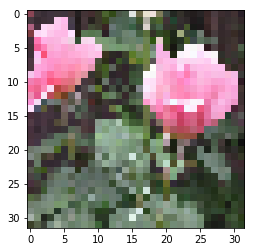

Predicted as-> tulip
Correct class-> rose


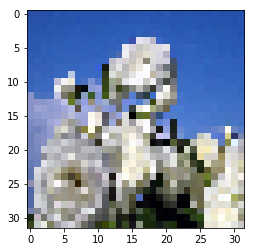

Predicted as-> daisy
Correct class-> rose


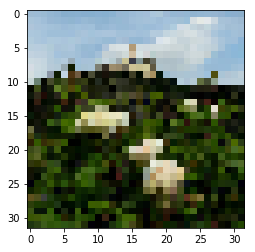

Predicted as-> daisy
Correct class-> rose


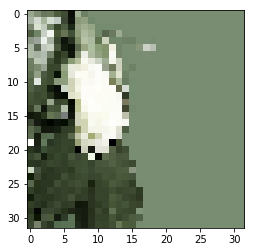

Predicted as-> dandelion
Correct class-> rose


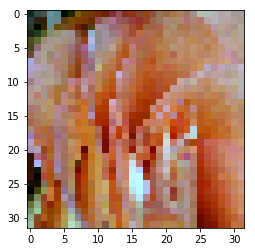

Predicted as-> tulip
Correct class-> rose


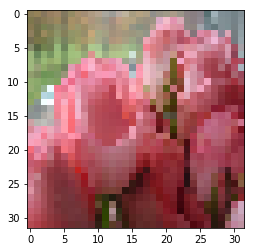

Predicted as-> tulip
Correct class-> rose


In [90]:
from matplotlib import pyplot as plt
for i in range(len(y_pred)):
    if(y_pred[i] != correct_class[i]):
        plt.imshow(X_test[i], interpolation='nearest')
        plt.show()
        print('Predicted as->', idx2class[(y_pred[i])])
        print('Correct class->', idx2class[(correct_class[i])])

Images that were incorrectly classified^^